# Lecture 3: Spatial modelling
This lecture:

- Example model
- Model challenges
- Last weeks challenges

# New Dates
    Friday     26-Oct 13:30 Individual-based modelling  
    Friday     09-Nov 13:30 Integration with other languages (C++, OpenCl)  
    Wednesday  14-Nov  9:00 Data handling, GIS, data pipelines  
    Tuesday    04-Dec  9:00 Machine learning (proposed Guest Lecture)  
    Tuesday    18-Dec  9:00 Python on the NIOZ Cluster  

# A model of mussel bed pattern formation

When a mussel bed is viewed from the air, they reveal a remarkable spatial organization. Mussel beds are strongly banded, with elongated mussel patches of 2-3 meters across alternating the open, bare areas of 3-4 meters.

![title](Images/mussels-bar.jpg "Mussel bed patterns in the Wadden sea")

To explain pattern formation in mussels, one needs to take into account the two most basic processes that determine mussel live: they need to eat, and they need to be safe. Below, I explain how this works.

Mussels make a living by consuming the microalgae – diatoms for the most – from the lower water layers of the water column. In dense beds, this can lead to fierce competition among the mussels for the algal food. Luckily for the mussels, the water flow, bringing fresh food for a long as the incoming tides flow. There are two imminent dangers threatening the life of a mussel: predation and wave dislodgement. They protect themselves against the danger by attaching themselves to other mussels using byssal threads, forming extensive mats of mussels. This means that mussels are more safe as there are more fellow mussels around.

# A simple model
A simple model suffices to show that the interaction of algal competition and density- dependent mortality can explain the formation patterns in mussels. This model describes the interaction of the concentration of algae $A$ in the lower water layer, and the biomass of mussels $M$ on the tidal flat:

$$
\begin{aligned}
\frac{\partial A}{\partial t}&= (A_{up}-A)f - \frac{c}{h}AM - V\nabla_{y} A \\
\frac{\partial M}{\partial t}&= ecAM - d_{M}\frac{k_{M}}{k_{M}+M}M + D \Delta M
\end{aligned}
$$

Here, $A_{up}$ is the concentration of algae in the upper water layer, $f$ is the exchange rate of water between the upper and lower water layer, $c$ is a consumption constant, $h$ is the depth of the lower water layer, $V$ is the advection rate of the water, $e$ is the assimilation efficientcy of the algal material into mussel tissue, $d_{M}$ is the mortality rate for isolated mussels, $k_{M}$ is the mussel density for which mortality has dropped by half, and finally $D$ is the dispersal constant for the mussels.

For more details, see the paper [here](https://pure.knaw.nl/ws/files/466748/VandeKoppel_ea_3467.pdf)

Below we implement this model in iPython.

### Loading some crucial python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time
%matplotlib inline

### Parameter definitions 
Here, the parameters that are found in the equations are given their value. For completeness, also their units and explanations are given.

In [2]:
# Algal Exchange parameters
Aup =  1.2       # g/m3     Algal concentration in upper layer 
h   =  0.10      # m        Height of the lower layer defined
f   =  100.0     # m3/m3/h  Exchange rate with upper layer

# Mussel update, growth & mortality parameters
c   =  0.1       # g/g/h    Maximal consumption rate of the mussels
e   =  0.2       # g/g      Trophic efficiency of mussels
dM  =  0.02      # g/g/h    Density dependent mortality rate of the mussels  
kM  =  150.0     # g/m2     Effect of density on mortality 

# Spatial movement parameters
D   =  0.0005    # m2/h     The diffusion constant for mussel movement
V   =  0.1*60*60 # m/h      Tidal advection constant 

### Mussel acceleration factor 
Mussel growth occurs on vastly different timescale then water flow. Water flow occurs at a timescale of seconds, while a mussel bed develops at the timescale of months. To avoid enormously long simulation times, we accelerate mussel growth, mortality, and dispersal by multiplying the mussel differential equation with a factor $\phi$ (Phi).  

In [3]:
Phi = 1000.0    # Speeding constant, accelerates mussel growth

### Parameters that determine how the simulation is run

In [4]:
LengthX     =  75.0   # Length of the physical landscape in the x dimension
LengthY     =  50.0   # Length of the physical landscape in the y dimension
Grid_Width  = 384     # Width of the grid
Grid_Height = 256     # Height of the grid

EndTime  = 180*24/Phi # total time
NumPlots = 180        # Number of times the figure is updated
dt       = 0.0002     # time step

### Some pre-computations

In [5]:
dx = LengthX/Grid_Width  # Space step in X
dy = LengthY/Grid_Height # Space step in Y
n  = int(EndTime/dt)     # The number of simulation iterations

### Colormap definitions
Creates a nice colormap from the color of wet mud (yellow-gray) to the color of dry mud with shells (whitish) to the dark color of the mussels themselves (assuming zero barnacle cover).

In [6]:
MusselColors = [(0.70, 0.67, 0.62), (0.96, 0.91, 0.93), (0.64, 0.64, 0.71),
                (0.44, 0.48, 0.56), (0.20, 0.27, 0.28), (0.00, 0.00, 0.00)]
MusselMap = LinearSegmentedColormap.from_list('MusselColors', MusselColors, N=100)

### Defining the functions that compute the first and second order derivatives

In [7]:
def d2_dxy2(Z): # Second order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    Ztop = np.roll(Z, 1, axis=1)
    Zbottom = np.roll(Z, -1, axis=1)
    return (Zleft + Zright   - 2 * Z) / dx**2 + (Ztop  + Zbottom  - 2 * Z) / dy**2

In [8]:
def d_dy(Z): # First order derivative that assumes periodic boundary conditions
    Ztop = np.roll(Z, 1, axis=1)
    Zcenter = Z[:,:]
    return (Zcenter - Ztop) / dy

### Initializing the data arrays and giving them starting values

In [9]:
np.random.seed(10)
A = np.zeros((Grid_Width, Grid_Height))+0.5
M = 100.0 + (np.random.rand(Grid_Width, Grid_Height)<0.05)*100.0

### The main simulation loop

In [10]:
# Defining a storage container Ms for all frames
Ms=np.zeros((Grid_Width, Grid_Height, NumPlots))
# Starting a timer:
start_time = time.time()
# We simulate the PDE with the finite difference method.
for j in range(NumPlots):

    for i in range(int(EndTime/ dt / NumPlots)):
        A, M = \
            A + dt * ( (Aup-A)*f - c/h*A*M - V*d_dy(A) ),\
            M + dt * Phi * ( e*c*A*M - dM*M*kM/(kM+M) + D * d2_dxy2(M))

    # We store the state of the system for NumPlot different times.
    Ms[:,:,j] = M

elapsed_time = time.time() - start_time
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Simulation took      : 53.6 (s)


### Plotting patterns in mussel beds

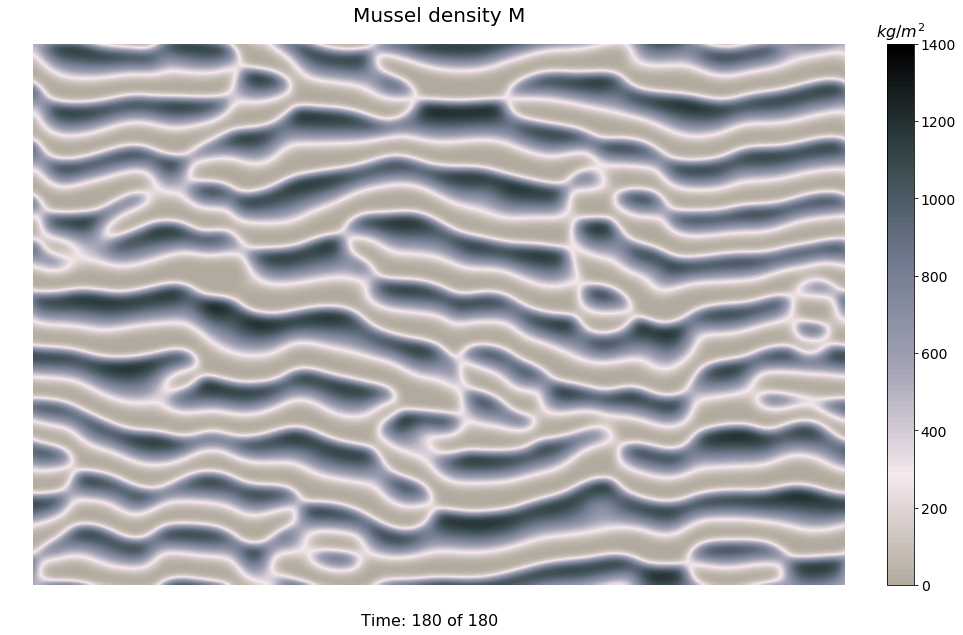

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

im = plt.imshow(Ms[:,:,NumPlots-1].T, animated=True, cmap=MusselMap, clim=(0,1400),
              interpolation='bilinear')
ax.set_axis_off()
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime*Phi/24, EndTime*Phi/24)), x=0.47, y=0.05, fontsize=16);
ax.set_title('Mussel density M', y=1.03, fontsize=20)

f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
f.ax.set_title('$kg/m^2$', fontsize=16)
f.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0.05, 0.94, 1])
fig.savefig('Mussels.png', dpi=120)

### Making an animation
Below, a movie is produced from the simulation results. To get the to work, ffmpeg must be installed (http://ffmpeg.org)

In [12]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global Ms
    im.set_array(Ms[:,:,i].T)
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumPlots*EndTime*Phi/24, EndTime*Phi/24));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

In [13]:
from IPython.display import HTML
HTML(ani.to_html5_video())

### Set up formatting for the movie files
For this to work, it is needed to install ffmpeg (www.ffmpeg.org)

In [14]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('Mussels.mp4', writer=writer, dpi=120)

# Model challenges
### The following topic are suggested

- Implement Klausmeier's model for arid vegetation patterns
- Implement Hassell & May's spiral-wave forming predator-prey model
- Cellular automata: Patterning of mussels on Rocky shores (challenging)
- Model water flow around a tussock (challenging)
- Implement a spatial model using FFT (challenging)
- Your idea

# Chris Klausmeier's model for arid vegetation patterns

On the edge of the desert, hbushland vegetation can develop strikingly regular patterns, in the form of stripes, dots, gaps, or over labyrinth shapes.

![title](https://johanvandekoppel.files.wordpress.com/2011/07/tigerbush-bar.jpg "Arid vegetation patterns")

To understand how these patterns form, Chris Klausmeier made a very simple model, that deals with how vegetation interactions with rainwater. Rainwater does not infiltrate well on the clayey soils where these patterns are typically found. However, where plants grow, they open up the soil, allowing rainfall to infiltrate, stimulating vegetation growth, leading to even better infiltration. In other words, where more plants grow, there is more water for the plants to consume. A very simple mathematical model can describe the local dynamics of water $w$ and plants $n$:
$$
\begin{aligned}
\frac{dw}{dt}&=a-w-wn^{2}+d_{w}\frac{dw}{dx} \\
\frac{dn}{dt}&= wn^{2} -mn +d_{w}\frac{d^{2}n}{dx^{2}}
\end{aligned}
$$
Assignment: Implement this model in iPython

# Hassell & May's spiral-wave forming predator-prey model

*Hassell, M.P., Comins, H.N. and May, R.M., 1991. Spatial structure and chaos in insect population dynamics. Nature, 353(6341), p.255*

<img src="Images/PredPrey-patterns.jpg" width="600" align="center" />

# Cellular automata: Patterning of mussels on Rocky shores (challenging)

*Guichard, F., P. M. Halpin, G. W. Allison, J. Lubchenco and B. A. Menge (2003). "Mussel disturbance dynamics: signatures of oceanographic forcing from local interactions." American Naturalist 161(6): 889-904.*

<img src="Images/MDM-patterns.jpg" width="500" align="center" />


# Model water flow around a tussock (challenging)

*Bouma, T.J., Temmerman, S., van Duren, L.A., Martini, E., Vandenbruwaene, W., Callaghan, 
D.P., Balke, T., Biermans, G., Klaassen, P.C., van Steeg, P. and Dekker, F., 2013. 
Organism traits determine the strength of scale-dependent bio-geomorphic feedbacks: a flume study on three intertidal plant species. Geomorphology, 180, pp.57-65.*

<img src="Images/SWE_Tussock.png" width="500" align="center" />

# Modelling a spatial model using a dispersal kernel (challenging)

When using standard simulation techniques (forward euler integration), we only compute the dispersal from each cell to the next. But why don't we compute immediately how after a longer period of time, the matter disperses of a much broader range of cells. We can compute how after a certain period of time diffusion has dispersed a certain material or species using the following equation:

$$
\begin{aligned}
K&=\frac{1}{\sqrt{4 \pi D t}}* e^{-\frac{x^2}{4 D t}} \\
\end{aligned}
$$

For an explanation, see: http://www.math.usu.edu/powell/wauclass/node3.html

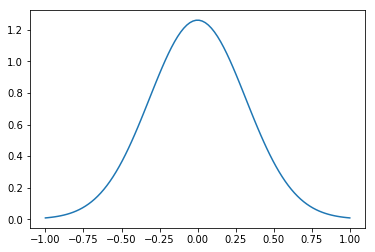

In [15]:
D=0.05; t=1; x=np.linspace(-1,1,100)
K=1/np.sqrt(4*np.pi*D*t)*np.exp(-x**2/(4*D*t));
plt.plot(x,K);

© Johan van de Koppel, NIOZ-Yerseke 2018